In [1]:
!pip install torch torchvision tqdm matplotlib numpy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np



In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
z_dim = 128
image_channels=3
num_epochs = 800
learning_rate = 3e-4

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to the folder containing Pablo Picasso's images
path = '_data/art/Picasso'

# Create a dataset for only the Pablo Picasso folder
dataset = datasets.ImageFolder(path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


## Define Variational Autoencoder

In [33]:
class VAE(nn.Module):
    def __init__(self, image_channels=image_channels, z_dim=z_dim):
        super(VAE, self).__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.ReLU()
        )
        
        # Dynamically compute h_dim based on encoder output
        test_input = torch.zeros(1, image_channels, IMAGE_SIZE, IMAGE_SIZE)
        test_output = self.encoder(test_input)
        self.h_dim = test_output.view(-1).size(0)  # Flattened size after encoder

        # Latent space
        self.fc_mu = nn.Linear(self.h_dim, z_dim)
        self.fc_logvar = nn.Linear(self.h_dim, z_dim)

        # Decoder network
        self.decoder_fc = nn.Linear(z_dim, self.h_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output of the encoder
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        # Ensure the reshaping matches [batch_size, 256, 4, 4]
        h = self.decoder_fc(z).view(-1, 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


# Instantiate the model and move it to the device
vae = VAE().to(device)

## Define Loss Function

In [34]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (using MSE or Binary Cross Entropy)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


## Train Variational Autoencoder

In [35]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        data = data.to(device)
        
        # Forward pass through the VAE
        recon_batch, mu, logvar = vae(data)
        
        # Compute the loss
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch [1/800], Loss: 3545.6688


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [2/800], Loss: 3499.2790


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [3/800], Loss: 3439.3037


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [4/800], Loss: 3373.2662


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [5/800], Loss: 3295.9301


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch [6/800], Loss: 3248.0711


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [7/800], Loss: 3190.8134


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [8/800], Loss: 3149.5400


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [9/800], Loss: 3044.1258


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [10/800], Loss: 2938.0920


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [11/800], Loss: 2832.4287


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [12/800], Loss: 2740.1721


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [13/800], Loss: 2693.1893


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [14/800], Loss: 2641.1398


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [15/800], Loss: 2589.7445


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [16/800], Loss: 2547.3132


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [17/800], Loss: 2506.0998


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [18/800], Loss: 2463.0666


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [19/800], Loss: 2425.1009


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [20/800], Loss: 2363.5714


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [21/800], Loss: 2293.3622


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [22/800], Loss: 2173.0102


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch [23/800], Loss: 2062.0823


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [24/800], Loss: 1986.8126


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [25/800], Loss: 1892.4393


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [26/800], Loss: 1846.1205


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [27/800], Loss: 1810.5735


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [28/800], Loss: 1806.3941


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [29/800], Loss: 1779.8583


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [30/800], Loss: 1719.0766


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [31/800], Loss: 1710.5757


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [32/800], Loss: 1666.2912


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]


Epoch [33/800], Loss: 1643.2731


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


Epoch [34/800], Loss: 1603.7841


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [35/800], Loss: 1590.1699


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [36/800], Loss: 1573.4359


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [37/800], Loss: 1558.7729


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [38/800], Loss: 1550.5466


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [39/800], Loss: 1524.6457


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [40/800], Loss: 1510.3140


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [41/800], Loss: 1479.0700


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [42/800], Loss: 1449.2584


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [43/800], Loss: 1440.9334


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [44/800], Loss: 1417.2800


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [45/800], Loss: 1417.5195


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [46/800], Loss: 1374.5725


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [47/800], Loss: 1408.5870


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [48/800], Loss: 1396.8487


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [49/800], Loss: 1340.6932


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [50/800], Loss: 1339.3254


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [51/800], Loss: 1313.4504


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [52/800], Loss: 1311.4430


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [53/800], Loss: 1283.4439


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [54/800], Loss: 1253.7768


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [55/800], Loss: 1258.7845


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [56/800], Loss: 1243.6365


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [57/800], Loss: 1225.4181


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]


Epoch [58/800], Loss: 1211.1488


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [59/800], Loss: 1207.9318


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [60/800], Loss: 1207.4772


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [61/800], Loss: 1198.4628


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [62/800], Loss: 1191.0714


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [63/800], Loss: 1187.1652


100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


Epoch [64/800], Loss: 1187.7307


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Epoch [65/800], Loss: 1169.7688


100%|██████████| 5/5 [00:00<00:00,  8.66it/s]


Epoch [66/800], Loss: 1160.3242


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [67/800], Loss: 1131.8572


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [68/800], Loss: 1143.3218


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [69/800], Loss: 1160.7621


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [70/800], Loss: 1141.3323


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [71/800], Loss: 1136.2532


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [72/800], Loss: 1123.5653


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [73/800], Loss: 1137.4485


100%|██████████| 5/5 [00:00<00:00,  8.43it/s]


Epoch [74/800], Loss: 1128.2731


100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch [75/800], Loss: 1103.3162


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [76/800], Loss: 1068.8911


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [77/800], Loss: 1062.4167


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [78/800], Loss: 1047.7983


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [79/800], Loss: 1031.2968


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [80/800], Loss: 1021.2250


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [81/800], Loss: 1010.9250


100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


Epoch [82/800], Loss: 1009.3795


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch [83/800], Loss: 1005.4270


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [84/800], Loss: 1006.5682


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [85/800], Loss: 993.9071


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [86/800], Loss: 995.4369


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [87/800], Loss: 989.2149


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [88/800], Loss: 1013.6448


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [89/800], Loss: 995.3224


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [90/800], Loss: 989.5306


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [91/800], Loss: 968.2555


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [92/800], Loss: 963.4592


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [93/800], Loss: 962.3516


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [94/800], Loss: 960.1866


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [95/800], Loss: 944.7795


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [96/800], Loss: 931.9977


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [97/800], Loss: 930.6910


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [98/800], Loss: 930.0225


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [99/800], Loss: 930.0719


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [100/800], Loss: 922.8155


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [101/800], Loss: 915.9492


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [102/800], Loss: 915.7244


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [103/800], Loss: 914.2581


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [104/800], Loss: 913.8055


100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch [105/800], Loss: 927.5607


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [106/800], Loss: 928.9812


100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch [107/800], Loss: 947.4035


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [108/800], Loss: 912.5266


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [109/800], Loss: 909.9358


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [110/800], Loss: 902.0918


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [111/800], Loss: 874.8318


100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch [112/800], Loss: 863.3372


100%|██████████| 5/5 [00:00<00:00,  8.41it/s]


Epoch [113/800], Loss: 866.3032


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [114/800], Loss: 847.9497


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [115/800], Loss: 855.2063


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [116/800], Loss: 838.1961


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [117/800], Loss: 840.2567


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [118/800], Loss: 828.4605


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [119/800], Loss: 822.1703


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [120/800], Loss: 820.9653


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [121/800], Loss: 827.2448


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [122/800], Loss: 824.0026


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [123/800], Loss: 823.1800


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [124/800], Loss: 816.8744


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [125/800], Loss: 814.4129


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [126/800], Loss: 817.4459


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [127/800], Loss: 827.8433


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [128/800], Loss: 834.6272


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [129/800], Loss: 827.4479


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [130/800], Loss: 819.0771


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [131/800], Loss: 847.7314


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [132/800], Loss: 803.7462


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [133/800], Loss: 820.3006


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [134/800], Loss: 803.7728


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [135/800], Loss: 781.6196


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch [136/800], Loss: 781.8878


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [137/800], Loss: 768.4502


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [138/800], Loss: 767.8346


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [139/800], Loss: 759.8735


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [140/800], Loss: 764.3744


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [141/800], Loss: 755.2200


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [142/800], Loss: 757.7295


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


Epoch [143/800], Loss: 744.1251


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [144/800], Loss: 743.6519


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [145/800], Loss: 746.5413


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [146/800], Loss: 740.1373


100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


Epoch [147/800], Loss: 731.8560


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Epoch [148/800], Loss: 736.6046


100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch [149/800], Loss: 725.7072


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [150/800], Loss: 726.5775


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [151/800], Loss: 722.7798


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [152/800], Loss: 714.0729


100%|██████████| 5/5 [00:00<00:00,  8.34it/s]


Epoch [153/800], Loss: 720.7358


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [154/800], Loss: 715.7840


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [155/800], Loss: 715.9141


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [156/800], Loss: 721.9675


100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch [157/800], Loss: 718.3916


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [158/800], Loss: 720.5477


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [159/800], Loss: 740.6998


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [160/800], Loss: 750.5255


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [161/800], Loss: 755.9912


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [162/800], Loss: 739.0618


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [163/800], Loss: 753.3265


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [164/800], Loss: 744.1616


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [165/800], Loss: 714.8693


100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


Epoch [166/800], Loss: 700.0708


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [167/800], Loss: 692.3113


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [168/800], Loss: 691.6531


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [169/800], Loss: 691.4465


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [170/800], Loss: 689.1225


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [171/800], Loss: 680.8119


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [172/800], Loss: 677.2811


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [173/800], Loss: 674.6394


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [174/800], Loss: 671.6241


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [175/800], Loss: 669.9839


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [176/800], Loss: 663.7746


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [177/800], Loss: 671.2840


100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


Epoch [178/800], Loss: 662.2462


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [179/800], Loss: 658.4475


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [180/800], Loss: 662.3373


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [181/800], Loss: 662.6258


100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


Epoch [182/800], Loss: 654.0330


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [183/800], Loss: 656.3981


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [184/800], Loss: 649.7939


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [185/800], Loss: 652.3126


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [186/800], Loss: 652.1319


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [187/800], Loss: 647.4622


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [188/800], Loss: 652.3027


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [189/800], Loss: 643.7304


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [190/800], Loss: 651.6482


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [191/800], Loss: 657.0261


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [192/800], Loss: 651.7725


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [193/800], Loss: 646.7227


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [194/800], Loss: 643.1617


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [195/800], Loss: 641.7912


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [196/800], Loss: 647.0096


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [197/800], Loss: 642.7536


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [198/800], Loss: 643.2973


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [199/800], Loss: 627.1866


100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Epoch [200/800], Loss: 633.8952


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [201/800], Loss: 626.1252


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [202/800], Loss: 643.2664


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [203/800], Loss: 655.0610


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [204/800], Loss: 651.8742


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [205/800], Loss: 661.0804


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [206/800], Loss: 638.3659


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [207/800], Loss: 632.2000


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [208/800], Loss: 639.3451


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [209/800], Loss: 625.9812


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch [210/800], Loss: 627.7937


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [211/800], Loss: 634.6756


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [212/800], Loss: 619.9568


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Epoch [213/800], Loss: 616.7229


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [214/800], Loss: 615.3857


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [215/800], Loss: 605.4637


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [216/800], Loss: 604.8373


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [217/800], Loss: 598.3620


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [218/800], Loss: 597.1854


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Epoch [219/800], Loss: 601.0206


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [220/800], Loss: 603.5690


100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch [221/800], Loss: 608.4634


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [222/800], Loss: 610.4600


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [223/800], Loss: 606.5651


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [224/800], Loss: 595.8671


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [225/800], Loss: 591.8361


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [226/800], Loss: 598.7643


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [227/800], Loss: 591.4628


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [228/800], Loss: 594.2447


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [229/800], Loss: 591.0441


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [230/800], Loss: 588.1831


100%|██████████| 5/5 [00:00<00:00,  8.43it/s]


Epoch [231/800], Loss: 585.6069


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [232/800], Loss: 586.7264


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


Epoch [233/800], Loss: 593.4953


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [234/800], Loss: 593.7833


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [235/800], Loss: 586.7244


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [236/800], Loss: 584.8199


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch [237/800], Loss: 583.7848


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [238/800], Loss: 573.8254


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [239/800], Loss: 581.3207


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [240/800], Loss: 595.0525


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [241/800], Loss: 584.6797


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [242/800], Loss: 579.9207


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [243/800], Loss: 575.2053


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [244/800], Loss: 581.1729


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [245/800], Loss: 578.0674


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [246/800], Loss: 584.5589


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [247/800], Loss: 575.9742


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [248/800], Loss: 571.0465


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [249/800], Loss: 568.6620


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [250/800], Loss: 564.1699


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [251/800], Loss: 562.5492


100%|██████████| 5/5 [00:00<00:00,  8.34it/s]


Epoch [252/800], Loss: 566.1060


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [253/800], Loss: 563.1955


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [254/800], Loss: 564.2977


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [255/800], Loss: 557.5931


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [256/800], Loss: 556.5028


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [257/800], Loss: 560.9801


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [258/800], Loss: 562.1362


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [259/800], Loss: 554.5252


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [260/800], Loss: 544.4796


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [261/800], Loss: 547.0996


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [262/800], Loss: 547.7208


100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Epoch [263/800], Loss: 552.5841


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [264/800], Loss: 559.8640


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [265/800], Loss: 569.8150


100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch [266/800], Loss: 561.8952


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [267/800], Loss: 550.1740


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [268/800], Loss: 545.4790


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [269/800], Loss: 544.0810


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [270/800], Loss: 544.6948


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [271/800], Loss: 537.3674


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [272/800], Loss: 540.6698


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Epoch [273/800], Loss: 544.8453


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [274/800], Loss: 544.3048


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [275/800], Loss: 560.6790


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [276/800], Loss: 580.4929


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Epoch [277/800], Loss: 584.7380


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [278/800], Loss: 560.0106


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [279/800], Loss: 557.5002


100%|██████████| 5/5 [00:00<00:00,  8.34it/s]


Epoch [280/800], Loss: 551.7835


100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


Epoch [281/800], Loss: 540.8478


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [282/800], Loss: 543.5533


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [283/800], Loss: 535.2223


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [284/800], Loss: 528.3171


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [285/800], Loss: 528.5781


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [286/800], Loss: 528.0516


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [287/800], Loss: 525.2436


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [288/800], Loss: 525.0990


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [289/800], Loss: 525.5510


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [290/800], Loss: 529.3238


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [291/800], Loss: 526.0588


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [292/800], Loss: 523.8292


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [293/800], Loss: 522.3210


100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


Epoch [294/800], Loss: 518.4170


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [295/800], Loss: 520.8677


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [296/800], Loss: 521.3611


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [297/800], Loss: 522.4767


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [298/800], Loss: 517.7289


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [299/800], Loss: 518.2356


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [300/800], Loss: 510.1248


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [301/800], Loss: 511.2135


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [302/800], Loss: 510.5169


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [303/800], Loss: 511.3580


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [304/800], Loss: 512.1829


100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch [305/800], Loss: 517.4898


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [306/800], Loss: 514.3991


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch [307/800], Loss: 511.4663


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [308/800], Loss: 512.9782


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [309/800], Loss: 507.0027


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [310/800], Loss: 505.1228


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [311/800], Loss: 506.4096


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [312/800], Loss: 510.7365


100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch [313/800], Loss: 507.7628


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [314/800], Loss: 503.7208


100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


Epoch [315/800], Loss: 507.3722


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [316/800], Loss: 500.6417


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [317/800], Loss: 502.2704


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [318/800], Loss: 496.7296


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [319/800], Loss: 496.5343


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [320/800], Loss: 493.7412


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [321/800], Loss: 492.3010


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [322/800], Loss: 495.8666


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [323/800], Loss: 491.7547


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [324/800], Loss: 493.3721


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [325/800], Loss: 489.4722


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Epoch [326/800], Loss: 492.7160


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [327/800], Loss: 492.4672


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [328/800], Loss: 497.7242


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [329/800], Loss: 494.4260


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [330/800], Loss: 493.7599


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [331/800], Loss: 496.3132


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [332/800], Loss: 496.9948


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [333/800], Loss: 490.7083


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [334/800], Loss: 492.1390


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [335/800], Loss: 488.0438


100%|██████████| 5/5 [00:00<00:00,  8.27it/s]


Epoch [336/800], Loss: 489.4432


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [337/800], Loss: 486.9796


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [338/800], Loss: 481.9820


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [339/800], Loss: 485.7554


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [340/800], Loss: 483.8475


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [341/800], Loss: 482.8240


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [342/800], Loss: 492.3263


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [343/800], Loss: 489.7799


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [344/800], Loss: 495.6165


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [345/800], Loss: 488.8961


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [346/800], Loss: 491.6849


100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch [347/800], Loss: 486.8009


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [348/800], Loss: 488.8978


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]


Epoch [349/800], Loss: 488.7603


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [350/800], Loss: 484.6616


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [351/800], Loss: 483.6260


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [352/800], Loss: 484.2242


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [353/800], Loss: 482.2329


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [354/800], Loss: 486.9332


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


Epoch [355/800], Loss: 491.4193


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [356/800], Loss: 494.2897


100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


Epoch [357/800], Loss: 484.0732


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [358/800], Loss: 481.0220


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [359/800], Loss: 474.8794


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [360/800], Loss: 473.2193


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [361/800], Loss: 475.8679


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [362/800], Loss: 473.7558


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [363/800], Loss: 475.8856


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [364/800], Loss: 480.2923


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [365/800], Loss: 476.1760


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [366/800], Loss: 480.4824


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [367/800], Loss: 480.1177


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [368/800], Loss: 482.2828


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [369/800], Loss: 494.6634


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [370/800], Loss: 493.1753


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [371/800], Loss: 492.4557


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [372/800], Loss: 491.6007


100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


Epoch [373/800], Loss: 498.5523


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [374/800], Loss: 501.7675


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [375/800], Loss: 493.9059


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [376/800], Loss: 488.8652


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [377/800], Loss: 490.1382


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [378/800], Loss: 492.1049


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [379/800], Loss: 489.2255


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [380/800], Loss: 486.8498


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [381/800], Loss: 475.9017


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [382/800], Loss: 469.6550


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [383/800], Loss: 466.3033


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [384/800], Loss: 463.0243


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [385/800], Loss: 465.8820


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [386/800], Loss: 457.9311


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch [387/800], Loss: 458.9856


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [388/800], Loss: 461.7929


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [389/800], Loss: 459.2587


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [390/800], Loss: 459.2498


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [391/800], Loss: 457.8733


100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


Epoch [392/800], Loss: 460.4158


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [393/800], Loss: 456.9870


100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch [394/800], Loss: 457.6431


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [395/800], Loss: 457.8904


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [396/800], Loss: 459.3655


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [397/800], Loss: 459.0078


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Epoch [398/800], Loss: 455.3610


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [399/800], Loss: 460.3137


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [400/800], Loss: 457.6849


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [401/800], Loss: 457.0082


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [402/800], Loss: 457.9284


100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


Epoch [403/800], Loss: 452.8359


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [404/800], Loss: 450.1754


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch [405/800], Loss: 451.0907


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [406/800], Loss: 453.6023


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [407/800], Loss: 454.6662


100%|██████████| 5/5 [00:00<00:00,  8.50it/s]


Epoch [408/800], Loss: 456.6832


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [409/800], Loss: 450.4002


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [410/800], Loss: 451.9253


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [411/800], Loss: 450.7556


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [412/800], Loss: 452.8804


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [413/800], Loss: 451.9107


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [414/800], Loss: 446.8573


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [415/800], Loss: 449.4230


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [416/800], Loss: 449.0359


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [417/800], Loss: 450.7857


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [418/800], Loss: 446.2912


100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


Epoch [419/800], Loss: 448.1124


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [420/800], Loss: 451.9033


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [421/800], Loss: 450.4081


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [422/800], Loss: 450.9929


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [423/800], Loss: 450.6499


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [424/800], Loss: 449.2021


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [425/800], Loss: 446.1005


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [426/800], Loss: 443.2997


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [427/800], Loss: 438.9810


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [428/800], Loss: 439.9096


100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch [429/800], Loss: 439.5844


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [430/800], Loss: 445.6601


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [431/800], Loss: 443.1981


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [432/800], Loss: 438.9458


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [433/800], Loss: 438.2399


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [434/800], Loss: 448.4143


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [435/800], Loss: 454.1198


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [436/800], Loss: 448.5906


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [437/800], Loss: 443.6146


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [438/800], Loss: 444.9102


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [439/800], Loss: 442.7498


100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


Epoch [440/800], Loss: 444.6540


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [441/800], Loss: 454.9857


100%|██████████| 5/5 [00:00<00:00,  8.66it/s]


Epoch [442/800], Loss: 449.0378


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [443/800], Loss: 447.1738


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [444/800], Loss: 456.6361


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [445/800], Loss: 451.4498


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [446/800], Loss: 447.6546


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [447/800], Loss: 439.1105


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [448/800], Loss: 440.0729


100%|██████████| 5/5 [00:00<00:00,  8.66it/s]


Epoch [449/800], Loss: 441.4220


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [450/800], Loss: 437.7149


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [451/800], Loss: 438.6208


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [452/800], Loss: 436.5374


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [453/800], Loss: 438.5086


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [454/800], Loss: 433.6248


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [455/800], Loss: 433.3753


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [456/800], Loss: 429.7581


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [457/800], Loss: 430.2355


100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch [458/800], Loss: 431.0716


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [459/800], Loss: 433.6515


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [460/800], Loss: 434.4658


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [461/800], Loss: 436.9641


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [462/800], Loss: 439.7260


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [463/800], Loss: 443.0839


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [464/800], Loss: 432.0313


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [465/800], Loss: 431.4349


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [466/800], Loss: 431.8715


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [467/800], Loss: 426.5722


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [468/800], Loss: 425.9787


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [469/800], Loss: 425.2800


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [470/800], Loss: 420.3704


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [471/800], Loss: 419.4246


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [472/800], Loss: 420.2631


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [473/800], Loss: 421.6418


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [474/800], Loss: 424.5018


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [475/800], Loss: 422.4748


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [476/800], Loss: 424.6250


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [477/800], Loss: 430.7330


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch [478/800], Loss: 424.7272


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [479/800], Loss: 422.4991


100%|██████████| 5/5 [00:00<00:00,  8.41it/s]


Epoch [480/800], Loss: 423.1080


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [481/800], Loss: 423.8327


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [482/800], Loss: 420.7758


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [483/800], Loss: 419.6208


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [484/800], Loss: 419.3958


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [485/800], Loss: 426.9735


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [486/800], Loss: 428.9778


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [487/800], Loss: 428.4038


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [488/800], Loss: 425.8731


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [489/800], Loss: 423.8806


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [490/800], Loss: 427.1244


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [491/800], Loss: 426.3048


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [492/800], Loss: 426.7100


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [493/800], Loss: 420.6049


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [494/800], Loss: 414.4311


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [495/800], Loss: 418.6291


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [496/800], Loss: 421.1795


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [497/800], Loss: 417.1765


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [498/800], Loss: 416.8405


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [499/800], Loss: 419.7505


100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch [500/800], Loss: 419.7151


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [501/800], Loss: 420.9545


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [502/800], Loss: 419.2621


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [503/800], Loss: 430.8323


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [504/800], Loss: 430.6656


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [505/800], Loss: 433.1388


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [506/800], Loss: 431.4197


100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


Epoch [507/800], Loss: 427.8860


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [508/800], Loss: 425.3828


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [509/800], Loss: 428.9435


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [510/800], Loss: 426.8081


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch [511/800], Loss: 431.1395


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [512/800], Loss: 427.7075


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [513/800], Loss: 421.8038


100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


Epoch [514/800], Loss: 418.0909


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [515/800], Loss: 414.8508


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [516/800], Loss: 416.9349


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [517/800], Loss: 418.4301


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [518/800], Loss: 410.7366


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [519/800], Loss: 408.6303


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [520/800], Loss: 405.1832


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [521/800], Loss: 404.7131


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [522/800], Loss: 404.6508


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


Epoch [523/800], Loss: 402.4576


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [524/800], Loss: 406.5779


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [525/800], Loss: 411.3886


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [526/800], Loss: 406.0861


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [527/800], Loss: 404.8706


100%|██████████| 5/5 [00:00<00:00,  8.45it/s]


Epoch [528/800], Loss: 400.6716


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [529/800], Loss: 406.3675


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [530/800], Loss: 403.1693


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch [531/800], Loss: 406.1892


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [532/800], Loss: 403.4428


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [533/800], Loss: 400.8552


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [534/800], Loss: 403.0411


100%|██████████| 5/5 [00:00<00:00,  8.50it/s]


Epoch [535/800], Loss: 406.3829


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [536/800], Loss: 405.4112


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [537/800], Loss: 409.6190


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [538/800], Loss: 406.6318


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [539/800], Loss: 404.8456


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [540/800], Loss: 403.7344


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [541/800], Loss: 406.0785


100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch [542/800], Loss: 405.0429


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [543/800], Loss: 400.2168


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [544/800], Loss: 399.7655


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Epoch [545/800], Loss: 403.0430


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [546/800], Loss: 401.8711


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [547/800], Loss: 399.9597


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [548/800], Loss: 402.9957


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [549/800], Loss: 405.5132


100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


Epoch [550/800], Loss: 410.5245


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [551/800], Loss: 413.9914


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [552/800], Loss: 408.9898


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [553/800], Loss: 410.1921


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [554/800], Loss: 408.8862


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [555/800], Loss: 410.3018


100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Epoch [556/800], Loss: 408.3372


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch [557/800], Loss: 403.0406


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [558/800], Loss: 399.3943


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [559/800], Loss: 399.6556


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [560/800], Loss: 396.4016


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [561/800], Loss: 395.9223


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [562/800], Loss: 394.1203


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [563/800], Loss: 398.2508


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [564/800], Loss: 400.6942


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [565/800], Loss: 401.5636


100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch [566/800], Loss: 401.8542


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [567/800], Loss: 397.4304


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [568/800], Loss: 394.6121


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [569/800], Loss: 396.8102


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [570/800], Loss: 400.1032


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [571/800], Loss: 402.9878


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [572/800], Loss: 401.3757


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [573/800], Loss: 397.9310


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [574/800], Loss: 395.4502


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [575/800], Loss: 393.3745


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [576/800], Loss: 391.2370


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [577/800], Loss: 387.4495


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [578/800], Loss: 388.7127


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [579/800], Loss: 388.6177


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [580/800], Loss: 395.8002


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [581/800], Loss: 403.0725


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [582/800], Loss: 395.2242


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [583/800], Loss: 388.9304


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [584/800], Loss: 388.7690


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [585/800], Loss: 388.1908


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [586/800], Loss: 387.3259


100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch [587/800], Loss: 387.3021


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [588/800], Loss: 383.4387


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [589/800], Loss: 386.2195


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [590/800], Loss: 384.7425


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [591/800], Loss: 385.8938


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [592/800], Loss: 386.2541


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [593/800], Loss: 385.4070


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [594/800], Loss: 385.5860


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [595/800], Loss: 385.5178


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [596/800], Loss: 388.9784


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [597/800], Loss: 387.5726


100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch [598/800], Loss: 387.7309


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [599/800], Loss: 389.9283


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [600/800], Loss: 389.8002


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [601/800], Loss: 387.8218


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [602/800], Loss: 389.6496


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [603/800], Loss: 385.6625


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [604/800], Loss: 386.0465


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [605/800], Loss: 389.4828


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [606/800], Loss: 389.3734


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [607/800], Loss: 390.2499


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [608/800], Loss: 387.8467


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [609/800], Loss: 393.1236


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [610/800], Loss: 401.8695


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [611/800], Loss: 390.9358


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [612/800], Loss: 390.3477


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [613/800], Loss: 392.8353


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [614/800], Loss: 391.5373


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [615/800], Loss: 387.2643


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [616/800], Loss: 391.9813


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [617/800], Loss: 395.4606


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [618/800], Loss: 399.1696


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [619/800], Loss: 392.2717


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [620/800], Loss: 399.7530


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [621/800], Loss: 395.9373


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [622/800], Loss: 401.9844


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [623/800], Loss: 393.3189


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [624/800], Loss: 387.7582


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [625/800], Loss: 382.7535


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [626/800], Loss: 379.1530


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [627/800], Loss: 378.7502


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [628/800], Loss: 380.6932


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [629/800], Loss: 383.4806


100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


Epoch [630/800], Loss: 378.4117


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [631/800], Loss: 377.5728


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [632/800], Loss: 375.4390


100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch [633/800], Loss: 376.7342


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch [634/800], Loss: 375.8357


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [635/800], Loss: 374.6052


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [636/800], Loss: 372.0886


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [637/800], Loss: 375.6445


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [638/800], Loss: 374.2417


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [639/800], Loss: 373.2187


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [640/800], Loss: 375.1739


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [641/800], Loss: 373.7608


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [642/800], Loss: 373.6558


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [643/800], Loss: 376.6094


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [644/800], Loss: 379.5991


100%|██████████| 5/5 [00:00<00:00,  8.50it/s]


Epoch [645/800], Loss: 378.7453


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [646/800], Loss: 373.3558


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [647/800], Loss: 371.2647


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [648/800], Loss: 373.1049


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch [649/800], Loss: 373.7847


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [650/800], Loss: 371.4005


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [651/800], Loss: 371.3989


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [652/800], Loss: 370.7329


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [653/800], Loss: 374.7009


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [654/800], Loss: 373.1417


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [655/800], Loss: 369.3589


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [656/800], Loss: 367.9419


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [657/800], Loss: 370.3145


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [658/800], Loss: 368.6749


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [659/800], Loss: 368.5049


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch [660/800], Loss: 370.7215


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [661/800], Loss: 371.1122


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [662/800], Loss: 374.9012


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [663/800], Loss: 369.4841


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [664/800], Loss: 372.5446


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [665/800], Loss: 372.9230


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [666/800], Loss: 374.0561


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [667/800], Loss: 367.1968


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [668/800], Loss: 367.4018


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [669/800], Loss: 370.1205


100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


Epoch [670/800], Loss: 368.3856


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [671/800], Loss: 366.0927


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [672/800], Loss: 367.8274


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [673/800], Loss: 365.7840


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [674/800], Loss: 363.8797


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [675/800], Loss: 363.6914


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [676/800], Loss: 364.7750


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [677/800], Loss: 369.3476


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [678/800], Loss: 367.6440


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [679/800], Loss: 363.9510


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch [680/800], Loss: 364.6963


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch [681/800], Loss: 363.5766


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [682/800], Loss: 362.3212


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [683/800], Loss: 362.3648


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [684/800], Loss: 362.3790


100%|██████████| 5/5 [00:00<00:00,  8.45it/s]


Epoch [685/800], Loss: 364.6893


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [686/800], Loss: 366.7994


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [687/800], Loss: 371.6155


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [688/800], Loss: 365.9140


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [689/800], Loss: 365.2927


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [690/800], Loss: 362.4324


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [691/800], Loss: 363.9454


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [692/800], Loss: 366.4055


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [693/800], Loss: 365.6931


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [694/800], Loss: 368.7791


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [695/800], Loss: 373.6575


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [696/800], Loss: 373.9515


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [697/800], Loss: 369.8083


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [698/800], Loss: 372.1459


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [699/800], Loss: 379.1908


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [700/800], Loss: 377.3393


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [701/800], Loss: 379.9508


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [702/800], Loss: 385.0469


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [703/800], Loss: 410.8263


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [704/800], Loss: 418.9791


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [705/800], Loss: 409.8900


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [706/800], Loss: 399.3905


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [707/800], Loss: 404.4576


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [708/800], Loss: 397.4419


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [709/800], Loss: 400.1925


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [710/800], Loss: 389.8952


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [711/800], Loss: 402.3068


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch [712/800], Loss: 391.9558


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [713/800], Loss: 381.6337


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [714/800], Loss: 383.1961


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [715/800], Loss: 375.1698


100%|██████████| 5/5 [00:00<00:00,  8.81it/s]


Epoch [716/800], Loss: 368.3249


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [717/800], Loss: 370.7205


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [718/800], Loss: 362.9819


100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Epoch [719/800], Loss: 362.5306


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


Epoch [720/800], Loss: 358.1296


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [721/800], Loss: 357.6530


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]


Epoch [722/800], Loss: 359.7731


100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


Epoch [723/800], Loss: 356.6136


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [724/800], Loss: 358.6368


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [725/800], Loss: 356.6843


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [726/800], Loss: 355.6658


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [727/800], Loss: 356.6898


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Epoch [728/800], Loss: 354.9582


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [729/800], Loss: 354.7018


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [730/800], Loss: 352.0532


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch [731/800], Loss: 351.8253


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [732/800], Loss: 354.1247


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [733/800], Loss: 353.6380


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [734/800], Loss: 355.1909


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [735/800], Loss: 353.2763


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [736/800], Loss: 354.6045


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [737/800], Loss: 351.8823


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [738/800], Loss: 352.8591


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [739/800], Loss: 354.0369


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [740/800], Loss: 353.2388


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [741/800], Loss: 354.2210


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [742/800], Loss: 359.9973


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [743/800], Loss: 354.6356


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [744/800], Loss: 359.7627


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [745/800], Loss: 361.5288


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [746/800], Loss: 355.4640


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [747/800], Loss: 358.9660


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [748/800], Loss: 355.6368


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [749/800], Loss: 355.2073


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [750/800], Loss: 350.9547


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch [751/800], Loss: 353.2097


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [752/800], Loss: 350.3701


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [753/800], Loss: 351.8691


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [754/800], Loss: 351.2493


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [755/800], Loss: 350.4047


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [756/800], Loss: 348.2092


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [757/800], Loss: 349.1147


100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch [758/800], Loss: 348.0654


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [759/800], Loss: 351.9092


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [760/800], Loss: 352.8888


100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch [761/800], Loss: 349.1043


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [762/800], Loss: 351.5944


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [763/800], Loss: 349.1896


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [764/800], Loss: 351.5049


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Epoch [765/800], Loss: 349.2485


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [766/800], Loss: 347.8647


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch [767/800], Loss: 347.1822


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch [768/800], Loss: 348.3908


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch [769/800], Loss: 349.2477


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [770/800], Loss: 350.5672


100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


Epoch [771/800], Loss: 352.5402


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]


Epoch [772/800], Loss: 350.5345


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [773/800], Loss: 348.8280


100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


Epoch [774/800], Loss: 349.3415


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch [775/800], Loss: 350.1129


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch [776/800], Loss: 347.8952


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [777/800], Loss: 351.9449


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [778/800], Loss: 348.9250


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [779/800], Loss: 349.2140


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [780/800], Loss: 348.3517


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [781/800], Loss: 349.5831


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [782/800], Loss: 347.8512


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [783/800], Loss: 351.3881


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [784/800], Loss: 351.4668


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [785/800], Loss: 353.7897


100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Epoch [786/800], Loss: 353.3095


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [787/800], Loss: 353.6266


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [788/800], Loss: 357.0067


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [789/800], Loss: 355.2857


100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Epoch [790/800], Loss: 357.1384


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [791/800], Loss: 368.8276


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


Epoch [792/800], Loss: 362.5475


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch [793/800], Loss: 361.1952


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [794/800], Loss: 363.6709


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch [795/800], Loss: 358.5258


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [796/800], Loss: 356.5595


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch [797/800], Loss: 354.7773


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [798/800], Loss: 349.0970


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [799/800], Loss: 350.5223


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]

Epoch [800/800], Loss: 347.6865


## Generate New Images

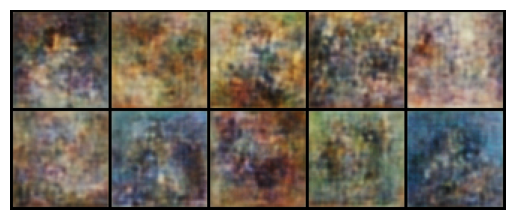

In [37]:
def generate_images(vae, num_images=10):
    vae.eval()
    
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(num_images, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

# Generate and visualize 10 images
generate_images(vae, num_images=10)


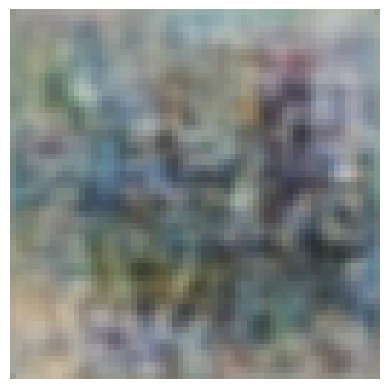

In [39]:
with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(1, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

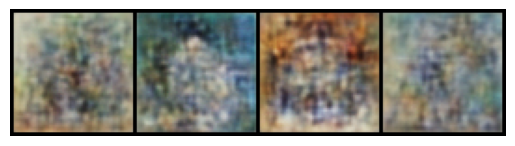

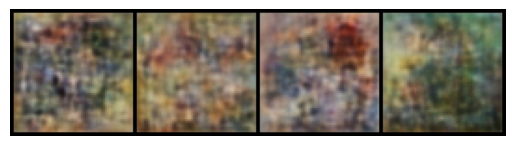

In [40]:
 with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(4, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

# Generate and visualize 10 images
generate_images(vae, num_images=4)